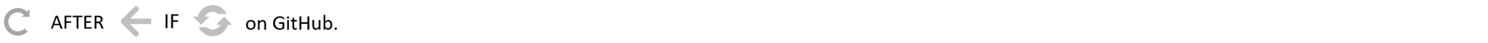

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)

# Wikipedia Notable Life Expectancy

## Notebook 2: Data Cleaning Part 1

### Contents

This notebook covers:
- Extracting missing `name` values
- Dropping entries with duplicate `link` values
- Separating `month-year` into `month` and `year`
- Treating `info`:
    - Dropping entries without digits (i.e., missing target `age`)
    - Extracting information within parentheses to `info_parenth`
    - Splitting `info` on commas into numbered `info_` columns
- Extracting `age` from:
    - `info_0`
    - `info_1`
- Exporting partially cleaned dataset to SQLite database


### Instructions
Options for Running this Notebook:
1.  Simplest:
    - Clone the repository and delete the following file that is generated by this notebook:
        - [wp_life_expect_clean1.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean1.db)
    - Navigate to the cloned repository in Jupyter and open the notebook to run it.

2. To run only this notebook:  Save the notebook and database file below to the same working directory:<sup>1</sup>
    -  Download the notebook:
        -  Click on <kbd>Raw</kbd> above.
        -  Save <kbd>Ctrl</kbd> + <kbd>S</kbd>
    -  Follow the link to the database file and click <kbd>Download</kbd>, then move file to the same directory as the notebook:<sup>2</sup>
        - [wp_life_expect_raw_complete.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_raw_complete.db)
    - In Jupyter, navigate to the directory in which the notebook and files are saved to open and run the notebook.  

    

### Data Dictionary for Loaded Version of Dataset
- **month_year**:  Month and year of the individual's death
- **day**:  Day of the month of the individual's death
- **name**:  Name of the individual
- **info**:  Combined Wikipedia-defined fields:
> Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference.<sup>3</sup>
>
- **link**:  Link to an individual's page
- **num_references**:  Number of references for individual's page

## Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To help with reading and manipulating data
import pandas as pd
import numpy as np
import re

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

<IPython.core.display.Javascript object>

## Data Overview

### Reading, Sampling, and Checking Data Shape

In [2]:
# Reading the wp_life_expect_raw_complete dataset
conn = sql.connect("wp_life_expect_raw_complete.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_raw_complete", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 133900 rows and 6 columns.


,month_year,day,name,info,link,num_references
0,January 1994,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21
1,January 1994,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,month_year,day,name,info,link,num_references
133898,June 2022,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion (1980) and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2
133899,June 2022,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,month_year,day,name,info,link,num_references
80157,December 2015,28,Eiji Kimizuka,", 63, Japanese general, Chief of Staff Ground Self-Defense Force (2011–2013), lung cancer.",https://en.wikipedia.org/wiki/Eiji_Kimizuka,7
121236,March 2021,5,Henri Gaudin,", 87, French architect.",https://en.wikipedia.org/wiki/Henri_Gaudin,4
45837,June 2010,4,Richard Dunn,", 73, American character actor (), stroke.",https://en.wikipedia.org/wiki/Richard_Dunn_(actor),6
79735,December 2015,2,Wally Roker,", 78, American R&B singer and music executive, complications following brain surgery.",https://en.wikipedia.org/wiki/Wally_Roker,6
31020,July 2006,1,Michael Barton,", 91, English Surrey cricketer and president.",https://en.wikipedia.org/wiki/Michael_Barton_(cricketer),1


<IPython.core.display.Javascript object>

#### Observations:
- There are 133,900 rows and 6 columns.
- `month_year` contains the month and year of death, while `day` contains the day of the month of death.
- `name` is the notable person's name.  It is a nominal feature that will not be used for analysis, but will be retained for any referencing needs.
- `info` contains multiple items, as expected.
- `link` is typically the url to the notable person's individual Wikipedia page.  If such a page does not exist, there is either a non-working link (https://en.wikipedia.orgNone), or the link is to a page with a message that the page does not exist for that individual.  `link` is intended to be used as a unique identifier for all entries, except the 6 with the non-working link, which do have unique `name` values from each other.  We still need to verify that all other links are unique.<sup>4</sup>
- `num_references` contains the number of references on the notable person's individual Wikipedia page.  This feature serves as a proxy measure of notability.
- Prior to EDA, our task will be to extract the individual elements that are comined in `month_year` and `info` columns.

### Checking Data Types, Duplicates, and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133900 entries, 0 to 133899
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   month_year      133900 non-null  object
 1   day             133900 non-null  object
 2   name            133894 non-null  object
 3   info            133900 non-null  object
 4   link            133900 non-null  object
 5   num_references  133900 non-null  object
dtypes: object(6)
memory usage: 6.1+ MB


<IPython.core.display.Javascript object>

In [6]:
# Checking duplicate rows
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [7]:
# Check percentage of null values by column
df.isnull().sum() / df.count() * 100

month_year        0.000000
day               0.000000
name              0.004481
info              0.000000
link              0.000000
num_references    0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [8]:
# Checking number of missing values per row
df.isnull().sum(axis=1).value_counts()

0    133894
1         6
dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- Our dataset was saved to and read from the database without any hiccups.
- As expected, we have 6 entries that are missing `name`, but we will find it in their `info` values.
- All columns are currently of object type.  We will need to appropriately typecast them after separating the information in `month_year` and `info`.
- We do not have any duplicate entries, but we will need to verify that all links are unique.  If an individual's death was entered on more than one date, there could be more than one entry for the individual.

## Data Cleaning

### Extracting Missing `name` Values

In [9]:
# Checking rows with missing name values
missing_name = df[df["name"].isna()]
missing_name

,month_year,day,name,info,link,num_references
18937,August 2001,11,None,"Kevin Kowalcyk, 2, known for eating a hamburger contaminated with E. coli O157:H7.",https://en.wikipedia.orgNone,0
24985,January 2004,22,None,"Vincent Palmer, 37, British criminal.",https://en.wikipedia.orgNone,0
27458,March 2005,1,None,"Barry Stigler, 57, American voice actor.",https://en.wikipedia.orgNone,0
34077,July 2007,11,None,"Nana Gualdi, 75, German singer and actress.",https://en.wikipedia.orgNone,0
64769,September 2013,29,None,"Scott Workman, 47, American stuntman (, , ), cancer.",https://en.wikipedia.orgNone,0
106613,September 2019,12,None,"Thami Shobede, 31, Singer Songwriter",https://en.wikipedia.orgNone,0


<IPython.core.display.Javascript object>

#### Observations:
- These rows vary from the main set as there is a substring containing the person's name at the start of the `info` string.
- As there are so few rows missing `name`, let us address this issue first.
- Within a for loop, we will split the `info` value into a list and extract `name` from the first list entry.  
- Then we will replace the name with an empty string within `info`.

In [10]:
# For loop to copy name value from info value and remove name from info value
treat_rows = missing_name.index
for i in treat_rows:
    info = df.loc[i, "info"]
    info_lst = info.split(sep=",", maxsplit=1)

    name = info_lst[0].strip()
    df.loc[i, "name"] = name
    df.loc[i, "info"] = re.sub(name, "", info).strip()

# Re-check rows
df.loc[treat_rows, :]

,month_year,day,name,info,link,num_references
18937,August 2001,11,Kevin Kowalcyk,", 2, known for eating a hamburger contaminated with E. coli O157:H7.",https://en.wikipedia.orgNone,0
24985,January 2004,22,Vincent Palmer,", 37, British criminal.",https://en.wikipedia.orgNone,0
27458,March 2005,1,Barry Stigler,", 57, American voice actor.",https://en.wikipedia.orgNone,0
34077,July 2007,11,Nana Gualdi,", 75, German singer and actress.",https://en.wikipedia.orgNone,0
64769,September 2013,29,Scott Workman,", 47, American stuntman (, , ), cancer.",https://en.wikipedia.orgNone,0
106613,September 2019,12,Thami Shobede,", 31, Singer Songwriter",https://en.wikipedia.orgNone,0


<IPython.core.display.Javascript object>

#### Observations:
- Missing `name` values have been addressed and those names have been removed from `info` values.
- Now, we can check for any duplicate links (aside from the 6 above) and remove entries that have duplicate links.

In [11]:
# Checking number and sample of rows with duplicate links
rows_to_check = df[
    (df["link"].duplicated()) & (df["link"] != "https://en.wikipedia.orgNone")
].index
print(f"There are {len(rows_to_check)} individuals with repeated links.")

# Checking a sample of rows
df.loc[rows_to_check, :].sample(5)

There are 125 individuals with repeated links.


,month_year,day,name,info,link,num_references
7172,October 1996,28,Sheldon Vanauken,", 82, American journalist, lung cancer.",https://en.wikipedia.org/wiki/Sheldon_Vanauken,28
23963,August 2003,18,Zachary Turner,", 1, American boy, murder–suicide, his killing is documented in the movie Dear Zachary",https://en.wikipedia.org/wiki/Murder_of_Zachary_Turner,23
26759,November 2004,29,Molly Weir,", 94, British TV and radio actress.",https://en.wikipedia.org/wiki/Molly_Weir,11
3939,July 1995,24,Marjorie Cameron,", 73, American artist, actress, and occultist.",https://en.wikipedia.org/wiki/Marjorie_Cameron,121
16763,October 2000,14,Tony Roper,", 35, American stock car racing driver, racing accident.",https://en.wikipedia.org/wiki/Tony_Roper_(racing_driver),3


<IPython.core.display.Javascript object>

#### Observations:
- There are 125 individuals with more than one entry.
- Let us take a look at an example.

In [12]:
# Checking an example of an individual with duplicate entries
df[df["link"] == "https://en.wikipedia.org/wiki/Sally_Mansfield"]

,month_year,day,name,info,link,num_references
17479,January 2001,27,Sally Mansfield,", 77, American actress, lung cancer.",https://en.wikipedia.org/wiki/Sally_Mansfield,3
17490,January 2001,28,Sally Mansfield,", 80, American actress.",https://en.wikipedia.org/wiki/Sally_Mansfield,3


<IPython.core.display.Javascript object>

#### Observations:
- We can see that the duplication is a result of the death being entered twice, on two different days, on Wikipedia.
- It is also possible that some links appear more than once as they point to a page for an event or different associated person, but we will err on the side of avoiding repeating entries for one individual.
- For entries with duplicate links, we will opt to keep the first entry and drop the others.  A duplicate after-the-fact entry seems more plausible than entering a death before it has occurred.

#### Dropping Duplicate Rows for Entries with Duplicate `link`

In [13]:
# Dropping duplicate rows for entries for entries with duplicate link values
rows_to_drop = rows_to_check.copy()
df.drop(rows_to_drop, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(133775, 6)

<IPython.core.display.Javascript object>

In [14]:
# Re-check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133775 entries, 0 to 133774
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   month_year      133775 non-null  object
 1   day             133775 non-null  object
 2   name            133775 non-null  object
 3   info            133775 non-null  object
 4   link            133775 non-null  object
 5   num_references  133775 non-null  object
dtypes: object(6)
memory usage: 6.1+ MB


<IPython.core.display.Javascript object>

#### Observations:
- We have no remaining missing values for the existing columns and the rows with duplicate `link` values have been dropped.
- Let us treat the `month_year` column next, by separating into two new columns `year` and `month`.

### Separating `month_year` into `month` and `year` and Dropping `month_year`

In [15]:
# Separating month and year into 2 columns and typecasting year as integer
df.loc[:, "year"] = df["month_year"].apply(lambda x: x.split(sep=" ")[1].strip())
df["year"] = df["year"].apply(lambda x: int(x))

df.loc[:, "month"] = df["month_year"].apply(lambda x: x.split(sep=" ")[0])
df.head(2)

,month_year,day,name,info,link,num_references,year,month
0,January 1994,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January
1,January 1994,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January


<IPython.core.display.Javascript object>

In [16]:
# Dropping month_year column
df.drop("month_year", axis=1, inplace=True)
df.head(2)

,day,name,info,link,num_references,year,month
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January


<IPython.core.display.Javascript object>

#### Observations:
- With `month` and `year` separated, we can move on to treating the `info` column.

### Treating `info`
First, we will define two functions to help identify rows that match a given regular expression pattern or list of patterns.  Then, we will start by examining the `info` column in a sample of the dataset.

#### Function to Save Indices of Rows Matching Regular Expressions Pattern to a List and Print Number of Rows with Match

In [17]:
# Define a function that takes dataframe, column name, and re pattern as arguments and returns list of indices
# for which column value matches re pattern
def rows_with_pattern(dataframe, column, pattern):
    """
    Takes input of dataframe, column name, and re pattern 
    and returns list of indices for rows that contain match
    for pattern anywhere within value for given column.
    
    dataframe: dataframe
    column: column name
    pattern: re pattern
    """
    index_list = []

    for i in dataframe.index:
        item = dataframe.loc[i, column]
        match = re.search(pattern, item)
        if match:
            index_list.append(i)
    print(
        f"There are {len(index_list)} rows with matching pattern in column '{column}'."
    )
    return index_list

<IPython.core.display.Javascript object>

#### Function to Use `rows_with_pattern` Function for Multiple Regular Expression Patterns

In [18]:
# Define a function that calls rows_with_pattern function for multiple re patterns
# returning a single list of indices for all rows with any pattern match


def multiple_patterns(dataframe, column, patterns):
    """
    Takes input dataframe, column, and list of re patterns and returns single list 
    of indices for rows in which a match for any pattern is found with re.search
    
    dataframe: dataframe
    column: column name
    patterns: list of re patterns
    """
    rows_combined = []

    # For loop to check each pattern
    for pattern in patterns:

        # List and number of rows matching each pattern
        print(pattern)
        rows_to_check = rows_with_pattern(dataframe, column, pattern)
        print("")

        # Add list for each pattern to combined list
        rows_combined += rows_to_check

    return rows_combined

<IPython.core.display.Javascript object>

#### Checking a Sample

In [19]:
# Checking a sample of info
df.sample(5)

,day,name,info,link,num_references,year,month
121947,1,Emmanuel Gaillard,", 69, French lawyer.",https://en.wikipedia.org/wiki/Emmanuel_Gaillard,20,2021,April
21887,11,Betty Molesworth Allen,", 89, New Zealand botanist.",https://en.wikipedia.org/wiki/Betty_Molesworth_Allen,22,2002,October
124723,2,Elliot Lawrence,", 96, American jazz pianist, nine-time Emmy award winner.",https://en.wikipedia.org/wiki/Elliot_Lawrence,9,2021,July
129963,10,Gerald Tanner,", 100, Australian footballer (Richmond).",https://en.wikipedia.org/wiki/Gerald_Tanner,7,2022,January
58889,1,José Bénazéraf,", 90, French film director and producer.",https://en.wikipedia.org/wiki/Jos%C3%A9_B%C3%A9naz%C3%A9raf,10,2012,December


<IPython.core.display.Javascript object>

#### Observations:
- We can see that `info` has variety, so will take some cleaning effort:
    - There are number values for years in addition to ages.
    - There is extra information inside of parentheses, that we likely don't need.
    - Some entries lack cause of death.
    - Some entries have multiple roles listed, with separating commas.
    - There are nationalities with multiple words.
    - `info` contains capital letters that are not part of citizenship.
- A strategic approach to cleaning the `info` column is needed, as follows:
    1. Drop all entries that are lacking digits in `info`, as they are missing the target `age` information.
    2. Extract any parentheses and their contents from `info` to new column `info_parenth`, as it likely won't be needed but we will preserve it, at lesast for now.
    3. Split `info` on "," and save to new numbered `info` columns that will flow left to right.
    3. Begin extracting age data from `info_0` and proceed left to right through the numbered `info` columns.

#### Step 1: Checking and Dropping Rows Lacking Digits (and therefore Age Data) within `info`

In [20]:
# Column to check
column = "info"

# Dataframe to check
dataframe = df

# Pattern for re
pattern = r"\d"

# Finding indices of rows that have pattern/digits and number of rows that do not have digits
has_digits = rows_with_pattern(dataframe, column, pattern)
print(
    f"\nThere are {len(df) - len(has_digits)} rows without numbers in the info column."
)

# Overwriting df with only rows that contain a digit in info column, resetting index, and checking new shape
df = df.loc[has_digits, :]
df.reset_index(inplace=True, drop=True)
df.shape

There are 132852 rows with matching pattern in column 'info'.

There are 923 rows without numbers in the info column.


(132852, 7)

<IPython.core.display.Javascript object>

#### Observations:
- 923 rows were removed as they lacked any digits and, therefore, the target data for `age`.
- The resultant number of rows matches the rows containing digits.
- Next, we will extract parentheses and their contents from `info` to a new column `info_parenth`.

#### Step 2: Removing Information within Parentheses from `info` and saving to new column `info_parenth`

In [21]:
# Column to check
column = "info"

# Dataframe to check
dataframe = df

# Regular expression for parenthetical
pattern = r"\(.*\)"

# Finding indices of rows that have pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking a sample of rows
df.loc[rows_to_check, :].sample(2)

There are 50003 rows with matching pattern in column 'info'.


,day,name,info,link,num_references,year,month
17508,12,"Morton Downey, Jr.",", 67, American television personality (), lung cancer.",https://en.wikipedia.org/wiki/Morton_Downey_Jr.,52,2001,March
107033,20,Meddie Kaggwa,", 64, Ugandan lawyer and politician, Chairman of the Uganda Human Rights Commission (since 2009).",https://en.wikipedia.org/wiki/Meddie_Kaggwa,5,2019,November


<IPython.core.display.Javascript object>

In [22]:
# For loop to extract parenthetical from info to info_parenth
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        df.loc[index, "info_parenth"] = match.group(0)
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Rechecking number and example rows after treatment
recheck_rows = rows_with_pattern(dataframe, column, pattern)

# Recheck a sample of treated rows
df.loc[rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info'.


,day,name,info,link,num_references,year,month,info_parenth
99367,10,Mahmoud Al-Samra,", 95, Jordanian academic and politician, Minister of Culture .",https://en.wikipedia.org/wiki/Mahmoud_Al-Samra,2,2018,November,(1991–1993)
97273,19,John Vigilante,", 33, American ice hockey player .",https://en.wikipedia.org/wiki/John_Vigilante,10,2018,July,"(Milwaukee Admirals, Syracuse Crunch, Plymouth Whalers)"


<IPython.core.display.Javascript object>

#### Observations:
- Parentheses and information within have been removed from `info` and assigned to `info_parenth`.
- Next, we will iterate through the rows, splitting `info` on commas and assigining the respective list values to new individual columns `info_0`, `info_1`, and so on.  
- Though we can keep in mind the Wikipedia-defined fields, we will take the general approach of treating column by column, after splitting `info`, varying as indicated to obtain specific feature information.

#### Step 3: Splitting `info` on Commas into Separate Columns

In [23]:
# For loop to split info on commas and separate into respective new columns
# and removing leading/trailing white space and periods
for i, item in enumerate(df["info"]):
    info_lst = item.split(",")

    for j in range(len(info_lst)):
        df.loc[i, f"info_{j}"] = info_lst[j].strip(" .")

# Checking the first 2 rows
df.head(2)

,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,NaN,,86,British dancer,ballet designer and director,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,NaN,,68,Irish economist,writer,and academic,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [24]:
# Checking the last 2 rows
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11
132850,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,(1980),,69,Russian volleyball player,Olympic champion and coach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132851,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,NaN,,86,Chinese engineer,member of the Chinese Academy of Engineering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- The `info` value is successfully divided and we can proceed through it column by column.
- There are 12 resultant new rows for the sections of `info` divided by commas (`info_parenth` excluded), indicating that some entries are quite detailed.
- We will now start our search for age data, starting with `info_0`.

## Extracting `age`

### `info_0`

In [25]:
# Checking unique value counts
df["info_0"].value_counts()

                                                                         132823
Sir                                                                           6
92                                                                            2
Douglas Scott                                                                 1
VC                                                                            1
Sir Woolwich West                                                             1
Sir Lord Justice of Appeal                                                    1
Dame MEP                                                                      1
83                                                                            1
Sir Governor-General                                                          1
Notable ice hockey players and coaches among the 44 killed in the :\n         1
Mike Alexander                                                                1
Colonel                                 

<IPython.core.display.Javascript object>

#### Observations:
- The vast majority of rows have an empty string for `info_0`.
- There is one row representing a group, rather than an individual, and we will drop it.
- We should verify the name and age information for the remainder of unique values in `info_0`.

#### Dropping Entry for Group

In [26]:
# Checking the entry representing a group
group_entry = df[
    df["info_0"]
    == "Notable ice hockey players and coaches among the 44 killed in the :\n"
]
group_entry

,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11
51030,7,2011 Lokomotiv Yaroslavl plane crash,Notable ice hockey players and coaches among the 44 killed in the :\n,https://en.wikipedia.org/wiki/2011_Lokomotiv_Yaroslavl_plane_crash,95,2011,September,NaN,Notable ice hockey players and coaches among the 44 killed in the :\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [27]:
# Dropping group entry, resetting index, and checking new shape of df
df.drop(group_entry.index, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(132851, 20)

<IPython.core.display.Javascript object>

#### Examining Rows with Atypical `info_0` Values

In [28]:
# Examining rows with atypical info_0 values
df[df["info_0"] != ""]

,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11
13995,5,slapstick,"Herbert Wiere, 91, Austrian-born American Wiere Brothers comedian, member of the",https://en.wikipedia.org/wiki/Slapstick,16,1999,August,NaN,Herbert Wiere,91,Austrian-born American Wiere Brothers comedian,member of the,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15828,15,NRG,"Kim Hwan-Sung, 19, A Member of .",https://en.wikipedia.org/wiki/NRG_(South_Korean_band),27,2000,June,NaN,Kim Hwan-Sung,19,A Member of,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18255,20,Demetreus Nix,"Douglas Scott, 20, High-school student murdered by .",https://en.wikipedia.org/w/index.php?title=Demetreus_Nix&action=edit&redlink=1,0,2001,June,NaN,Douglas Scott,20,High-school student murdered by,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18847,11,were killed,"Nearly 3,000 people September 11 attacks in the , including:\n",https://en.wikipedia.org/wiki/Casualties_of_the_September_11_attacks,176,2001,September,NaN,Nearly 3,000 people September 11 attacks in the,including:\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29531,10,James Yancey,"aka J Dilla, 32, American hip hop record producer and MC, lupus nephritis.",https://en.wikipedia.org/wiki/J_Dilla,56,2006,February,NaN,aka J Dilla,32,American hip hop record producer and MC,lupus nephritis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30098,2,"Sam Mokuahi, Jr.","aka ""Sammy Steamboat"", 71, American Hawaiian professional wrestler, complications from Alzheimer's disease.","https://en.wikipedia.org/wiki/Sam_Mokuahi,_Jr.",10,2006,May,NaN,"aka ""Sammy Steamboat""",71,American Hawaiian professional wrestler,complications from Alzheimer's disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30120,6,Flight Lieutenant,"Sarah-Jayne Mulvihill, 32, first British servicewoman to be killed in action in Iraq.",https://en.wikipedia.org/wiki/Flight_Lieutenant,12,2006,May,NaN,Sarah-Jayne Mulvihill,32,first British servicewoman to be killed in action in Iraq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30259,25,Julian Bullard,"Sir , 78, British diplomat.",https://en.wikipedia.org/wiki/Julian_Bullard,3,2006,May,NaN,Sir,78,British diplomat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30268,26,Horondino José da Silva,"aka ""Dino Sete Cordas"", 88, Brazilian virtuouso of the seven-string guitar.",https://en.wikipedia.org/wiki/Dino_7_Cordas,2,2006,May,NaN,"aka ""Dino Sete Cordas""",88,Brazilian virtuouso of the seven-string guitar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30273,26,Mahmoud al-Majzoub,"aka Abu Hamza, 41, Palestinian Islamic Jihad leader, assassination by bombing.",https://en.wikipedia.org/wiki/Mahmoud_al-Majzoub,2,2006,May,NaN,aka Abu Hamza,41,Palestinian Islamic Jihad leader,assassination by bombing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- The majority of rows contain additional aliases or titles within `info_0`, that we don't need, but we can leave in place for now, as we can drop the column as a whole, later.  
- There are a few rows that will need to be treated individually to correct the name value, as follows:
    1. Entry is for Mike Alexander whose band was Evile.
    2. Entry is for Herbert Wiere who performed slapstick comedy.
    3. Entry is for Sarah-Jayne Mulvihill who was a Flight Lieutenant.
    4. Entry is for Douglass Scott who was killed by Demetreus Nix.
    5. Entry is for Kim Hwan-Sung who was a member of the band NRG.
- We can replace the `name` value with the `info_0` value for these rows as well as proceed with hard-coding the correct values for info_2 and info_3 fields to match the Wikipedia pattern, but staying true to the information scraped.
- The row with "Nearly 3" value for `info_0` also represents a group, rather than an individual, so will be dropped, after treating the above rows.
- We will then proceed to extract age from `info_0` for the few rows that contain it here instead of in `info_1`.

#### Treating 5 rows with Name in `info_0`

In [29]:
# List of names values in info_0
values_lst = [
    "Mike Alexander",
    "Herbert Wiere",
    "Sarah-Jayne Mulvihill",
    "Douglas Scott",
    "Kim Hwan-Sung",
]

<IPython.core.display.Javascript object>

In [30]:
# For loop to copy name from info_0 to name
for i in df[df["info_0"].isin(values_lst)].index.to_list():
    df.loc[i, "name"] = df.loc[i, "info_0"]

# Hard-coding info_2 and info_3 values for Kim Hwan-Sung
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/NRG_(South_Korean_band)"
].index.to_list()
df.loc[index, "info_2"] = "South Korean musician"

df.loc[index, "info_3"] = "respiratory illness"

# # Hard-coding info_2 and info_3 values for Douglass Scott
index = df[
    df["link"]
    == "https://en.wikipedia.org/w/index.php?title=Demetreus_Nix&action=edit&redlink=1"
].index.to_list()
df.loc[index, "info_2"] = "student"

df.loc[index, "info_3"] = "murdered"

# # Hard-coding info_2 and info_3 values for Sarah-Jayne Mulvihill
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Flight_Lieutenant"
].index.to_list()
df.loc[index, "info_2"] = "British servicewoman"

df.loc[index, "info_3"] = "killed in action"

<IPython.core.display.Javascript object>

In [31]:
# Rechecking updated rows
df[df["info_0"].isin(values_lst)]

,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11
13995,5,Herbert Wiere,"Herbert Wiere, 91, Austrian-born American Wiere Brothers comedian, member of the",https://en.wikipedia.org/wiki/Slapstick,16,1999,August,NaN,Herbert Wiere,91,Austrian-born American Wiere Brothers comedian,member of the,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15828,15,Kim Hwan-Sung,"Kim Hwan-Sung, 19, A Member of .",https://en.wikipedia.org/wiki/NRG_(South_Korean_band),27,2000,June,NaN,Kim Hwan-Sung,19,South Korean musician,respiratory illness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18255,20,Douglas Scott,"Douglas Scott, 20, High-school student murdered by .",https://en.wikipedia.org/w/index.php?title=Demetreus_Nix&action=edit&redlink=1,0,2001,June,NaN,Douglas Scott,20,student,murdered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30120,6,Sarah-Jayne Mulvihill,"Sarah-Jayne Mulvihill, 32, first British servicewoman to be killed in action in Iraq.",https://en.wikipedia.org/wiki/Flight_Lieutenant,12,2006,May,NaN,Sarah-Jayne Mulvihill,32,British servicewoman,killed in action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42043,5,Mike Alexander,"Mike Alexander, 32, British bassist , pulmonary embolism.",https://en.wikipedia.org/wiki/Evile,82,2009,October,(),Mike Alexander,32,British bassist,pulmonary embolism,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Dropping Entry for Group

In [32]:
# Checking the entry representing a group
group_entry = df[df["info_0"] == "Nearly 3"]
group_entry

,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11
18847,11,were killed,"Nearly 3,000 people September 11 attacks in the , including:\n",https://en.wikipedia.org/wiki/Casualties_of_the_September_11_attacks,176,2001,September,NaN,Nearly 3,000 people September 11 attacks in the,including:\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [33]:
# Dropping group entry, resetting index, and checking new shape of df
df.drop(group_entry.index, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(132850, 20)

<IPython.core.display.Javascript object>

#### Extracting `age` from `info_0`

In [34]:
# Column to check
column = "info_0"

# Dataframe to check
dataframe = df

# Pattern for re
pattern = r"(\d{1,3})"

# Checking rows with pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking a sample of rows
df.loc[rows_to_check, :].sample(2)

There are 3 rows with matching pattern in column 'info_0'.


,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11
117266,11,Gotthilf Fischer,"92, German choral conductor .",https://en.wikipedia.org/wiki/Gotthilf_Fischer,4,2020,December,(Fischer-Chöre),92,German choral conductor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59511,24,Kristján Jóhannsson,"83, Icelandic Olympic athlete.",https://en.wikipedia.org/wiki/Kristj%C3%A1n_J%C3%B3hannsson_(athlete),2,2013,January,NaN,83,Icelandic Olympic athlete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [35]:
# For loop to extract age from info_0 to age
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        df.loc[index, "age"] = int(match.group(1))
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Rechecking number and example rows after treatment
recheck_rows = rows_with_pattern(dataframe, column, pattern)

# Recheck a sample of treated rows
df.loc[rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info_0'.


,day,name,info,link,num_references,year,month,info_parenth,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
32994,28,David Turnbull,". 92, American materials scientist.",https://en.wikipedia.org/wiki/David_Turnbull_(materials_scientist),8,2007,April,NaN,,American materials scientist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0
117266,11,Gotthilf Fischer,"92, German choral conductor .",https://en.wikipedia.org/wiki/Gotthilf_Fischer,4,2020,December,(Fischer-Chöre),,German choral conductor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0


<IPython.core.display.Javascript object>

#### Observations:
- The new `age` column has been added successfully.
- We are finished processing `info_0`, and we can drop it, as it no longer contains information that we need.

#### Re-checking Unique Values for `info_0` and Dropping the Column

In [36]:
# Re-checking unique values for info_0 prior to dropping it
df["info_0"].unique()

array(['', 'Herbert Wiere', 'Kim Hwan-Sung', 'Douglas Scott',
       'aka J Dilla', 'aka "Sammy Steamboat"', 'Sarah-Jayne Mulvihill',
       'Sir', 'aka "Dino Sete Cordas"', 'aka Abu Hamza', 'Sir Winchester',
       'Sir Edinburgh University', 'VC', 'Colonel', 'Mike Alexander',
       'Sir Governor-General', 'Dame MEP', 'Sir Lord Justice of Appeal',
       'Sir Woolwich West', 'Sir Premier'], dtype=object)

<IPython.core.display.Javascript object>

In [37]:
# Dropping info_0
df.drop("info_0", axis=1, inplace=True)

<IPython.core.display.Javascript object>

#### Observations:
- All of the age values were extracted from `info_0` and the column has been dropped.
- We are ready to move on to processing `info_1`, which should primarily consist of age values, per the defined Wikipedia fields.

### `info_1`

#### Unique Values

In [38]:
# Checking unique values
df["info_1"].unique()

array(['86', '68', '87', '93', '79', '50', '88', '72', '81', '80', '90',
       '85', '92', '58', '54', '96', '49', '77', '76', '43', '35', '83',
       '31', '64', '57', '52', '84', '78', '70', '73', '67', '99', '33',
       '75', '66', '74', '62', '61', '82', '38', '47', '56', '91', '89',
       '94', '45', '65', '97', '63', '69', '37', '53', '46', '60', '26',
       '71', '25', '59', '39–40', '23', '95', '42', '32', '51', '41',
       '55', '44', '98', '39', '100', '27', '28', '40', '30', '48', '34',
       '29', '36', '111', '22', '104', '14', '21', '106', '105', '18',
       '101', '102', '20', '73-74', '84-85', '67-68', '85-86', '89-90',
       '103', '49-50', '87-88', '107', '48-49', '19', '71-72', '2',
       '82-83', '88-89', '11-12', '63-64', '64-65', '24', '17', '69-70',
       '52-53', '39-40', '80-81', '51-52', '70–71', '66–67', '59-60',
       '94-95', '15', '108', '76-77', '1995', '37-38',
       'American politician', '55/56', '87–88',
       '90 Swedish Olympic sprinte

<IPython.core.display.Javascript object>

#### Observations:
- There is a lot of variety in `info_1` and in the format of the age data.
- Also, this field contains several values that we would expect in info_2 and beyond.
- Let us take the approach of extracting age values first.

#### Examining Unique Formats for Age Data

In [39]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# Pattern for re
pattern = r"\d"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking unique values for column
df.loc[rows_to_check, :][column].unique()

There are 132629 rows with matching pattern in column 'info_1'.


array(['86', '68', '87', '93', '79', '50', '88', '72', '81', '80', '90',
       '85', '92', '58', '54', '96', '49', '77', '76', '43', '35', '83',
       '31', '64', '57', '52', '84', '78', '70', '73', '67', '99', '33',
       '75', '66', '74', '62', '61', '82', '38', '47', '56', '91', '89',
       '94', '45', '65', '97', '63', '69', '37', '53', '46', '60', '26',
       '71', '25', '59', '39–40', '23', '95', '42', '32', '51', '41',
       '55', '44', '98', '39', '100', '27', '28', '40', '30', '48', '34',
       '29', '36', '111', '22', '104', '14', '21', '106', '105', '18',
       '101', '102', '20', '73-74', '84-85', '67-68', '85-86', '89-90',
       '103', '49-50', '87-88', '107', '48-49', '19', '71-72', '2',
       '82-83', '88-89', '11-12', '63-64', '64-65', '24', '17', '69-70',
       '52-53', '39-40', '80-81', '51-52', '70–71', '66–67', '59-60',
       '94-95', '15', '108', '76-77', '1995', '37-38', '55/56', '87–88',
       '90 Swedish Olympic sprinter', '6', '86-87', '62/63', '79

<IPython.core.display.Javascript object>

#### Observations:
- The data for age within `info_1` is in the following formats:  
    - single integer ("age", "age ", "age.")
    - range of 2 integers (separators "-", "–", "/", and " or ")
    - range of 2 integers with only unit value for second number ("age1/age2-2nd-digit")
    - age in months ("age-months" and "age months")
    - estimates ("c. age", "c.age",  "age?", "ages" (e.g. 80s), "age+"
- There are some specific rows that need to be examined, with the following values for `info_1`:
    - German Olympic sailor [1]
    - Taiwanese failed assassin in the 3-19 shooting incident
    - 255
    - 176
    - the first wild bear in Germany in 170 years
    - c. 3500
    - common chimpanzee 55
    - Maltese 15
    - c.1000
    - Tree of the Year 150
- There are additional 4-digit values that likely represent years or other information, such as flight number, etc.  Unless the information is preceded by "c." we will opt to exclude it.
- We will need to be strategic in the order in which we extract age from `info_1`.
- First, we will look at the atypical values listed above.

#### Examining Rows with Digits and Atypical Values for `info_1`

In [40]:
# List of atypical info_1 values for rows with digits
values_lst = [
    "German Olympic sailor [1]",
    "Taiwanese failed assassin in the 3-19 shooting incident",
    "255",
    "176",
    "the first wild bear in Germany in 170 years",
    "c. 3500",
    "common chimpanzee 55",
    "Maltese 15",
    "c.1000",
    "Tree of the Year 150",
]

df[df[column].isin(values_lst)]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
22652,17,Klaus Oldendorff,", German Olympic sailor [1]",https://en.wikipedia.org/wiki/Klaus_Oldendorff,1,2003,March,NaN,German Olympic sailor [1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24936,29,Chen Yi-hsiung,", Taiwanese failed assassin in the 3-19 shooting incident.",https://en.wikipedia.org/wiki/Chen_Yi-hsiung,4,2004,March,NaN,Taiwanese failed assassin in the 3-19 shooting incident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29809,23,Adwaita,", 255 , tortoise claimant for world's oldest animal, reputedly a former pet of General Clive, liver failure.",https://en.wikipedia.org/wiki/Adwaita,4,2006,March,(approximate age),255,tortoise claimant for world's oldest animal,reputedly a former pet of General Clive,liver failure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30476,23,Harriet,", 176, Galápagos tortoise believed to be the third oldest animal in the world and allegedly owned by Charles Darwin, heart failure.",https://en.wikipedia.org/wiki/Harriet_(tortoise),10,2006,June,NaN,176,Galápagos tortoise believed to be the third oldest animal in the world and allegedly owned by Charles Darwin,heart failure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30501,26,Bear JJ1,", the first wild bear in Germany in 170 years, shot to death.",https://en.wikipedia.org/wiki/Bear_JJ1,1,2006,June,(Bruno the Bear),the first wild bear in Germany in 170 years,shot to death,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52894,16,The Senator,", c. 3500, American pond cypress tree, largest in the world, fire.",https://en.wikipedia.org/wiki/The_Senator_(tree),11,2012,January,NaN,c. 3500,American pond cypress tree,largest in the world,fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55301,2,Oliver,", common chimpanzee 55, Congolese-born noted for his upright stature and humanlike traits.",https://en.wikipedia.org/wiki/Oliver_(chimpanzee),14,2012,June,NaN,common chimpanzee 55,Congolese-born noted for his upright stature and humanlike traits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55352,5,Lucky Diamond,", Maltese 15, American Guinness World Record dog, holder , cancer.",https://en.wikipedia.org/wiki/Lucky_Diamond_(dog),13,2012,June,(dog most photographed with celebrities),Maltese 15,American Guinness World Record dog,holder,cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86407,8,Pioneer Cabin Tree,", c.1000, American giant sequoia tree, storm damage.",https://en.wikipedia.org/wiki/Pioneer_Cabin_Tree,45,2017,January,NaN,c.1000,American giant sequoia tree,storm damage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118108,5,Happy Man Tree,", Tree of the Year 150, British plane tree, , cut down.",https://en.wikipedia.org/wiki/Happy_Man_Tree,23,2021,January,(2020),Tree of the Year 150,British plane tree,,cut down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- Age data is either missing or the entry is for a member of a non-human species (tortoise, chimpanzee, dog, or tree).
- Where age data is missing, we will drop the entry.  Age is missing for all of the human entries and for the bear, above.
- Let us retain non-human entries that do have age, as they may be interesting to examine in the future.

#### Selecting and Dropping Additional Rows Missing Age Data

In [41]:
# Creating a list of other_species entries to retain
other_species = ["tortoise", "tree", "chimpanzee", "dog"]

# For loop to create list of rows to drop
rows_to_drop = []
for index in df[df[column].isin(values_lst)].index:
    item = df.loc[index, "info"]
    if not any(species in item for species in other_species):
        rows_to_drop.append(index)

# Check rows to drop
df.loc[rows_to_drop, :]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
22652,17,Klaus Oldendorff,", German Olympic sailor [1]",https://en.wikipedia.org/wiki/Klaus_Oldendorff,1,2003,March,NaN,German Olympic sailor [1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24936,29,Chen Yi-hsiung,", Taiwanese failed assassin in the 3-19 shooting incident.",https://en.wikipedia.org/wiki/Chen_Yi-hsiung,4,2004,March,NaN,Taiwanese failed assassin in the 3-19 shooting incident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30501,26,Bear JJ1,", the first wild bear in Germany in 170 years, shot to death.",https://en.wikipedia.org/wiki/Bear_JJ1,1,2006,June,(Bruno the Bear),the first wild bear in Germany in 170 years,shot to death,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [42]:
# Dropping rows, resetting index, and checking new shape of df
df.drop(rows_to_drop, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(132847, 20)

<IPython.core.display.Javascript object>

#### Observations:
- With those rows addressed, we will begin extracting age in months and convert them to years.

### Extracting `age` from `info_1`

#### Step 1: Age in Months

In [43]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# Dictionary of patterns for months formats as keys and factor to convert to years
patterns = {
    r"(\d{1,3})(-months)": 12,
    r"(\d{1,3})( months)": 12,
}

# List and number of rows matching patterns
rows_to_check = multiple_patterns(dataframe, column, patterns)

# Checking rows
df.loc[rows_to_check, :]

(\d{1,3})(-months)
There are 1 rows with matching pattern in column 'info_1'.

(\d{1,3})( months)
There are 1 rows with matching pattern in column 'info_1'.



,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
30438,18,Chris and Cru Kahui,", 3-months, New Zealand child homicide victims.",https://en.wikipedia.org/wiki/Chris_and_Cru_Kahui,48,2006,June,NaN,3-months,New Zealand child homicide victims,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90355,28,Charlie Gard,", 11 months, British infant, subject of life support and parental rights case, MDDS.",https://en.wikipedia.org/wiki/Charlie_Gard_case,125,2017,July,NaN,11 months,British infant,subject of life support and parental rights case,MDDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [44]:
# For loop to extract age invmonths from info_1 and convert to years and save in age
for key, value in patterns.items():
    for index in rows_to_check:
        item = df.loc[index, column]
        match = re.search(key, item)
        if match:
            age = int(match.group(1)) / value
            df.loc[index, "age"] = age
            df.loc[index, column] = re.sub(key, "", df.loc[index, column]).strip()

# Re-check number of rows matching patterns
recheck_rows = multiple_patterns(dataframe, column, patterns)

# Checking treated rows
df.loc[rows_to_check, :]

(\d{1,3})(-months)
There are 0 rows with matching pattern in column 'info_1'.

(\d{1,3})( months)
There are 0 rows with matching pattern in column 'info_1'.



,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
30438,18,Chris and Cru Kahui,", 3-months, New Zealand child homicide victims.",https://en.wikipedia.org/wiki/Chris_and_Cru_Kahui,48,2006,June,NaN,,New Zealand child homicide victims,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000
90355,28,Charlie Gard,", 11 months, British infant, subject of life support and parental rights case, MDDS.",https://en.wikipedia.org/wiki/Charlie_Gard_case,125,2017,July,NaN,,British infant,subject of life support and parental rights case,MDDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916667


<IPython.core.display.Javascript object>

#### Observations:
- We have successfully captured the age in months values and converted them to years.
- Next, we will address entries that contain two age values as a range, starting first with those that have a single digit as the second number.

#### Step 2: Extracting `age` from `info_1` for Entries with Age Estimate Containing Age Range with 2 Values

#### Ranges with Single Digit as Upper-end

In [45]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# Pattern for re
pattern = r"(\d{1,3})(/)(\d)\b"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking sample of rows
df.loc[rows_to_check, :].sample(2)

There are 12 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
27328,12,Nelly Uchendu,", 54/5, Nigerian musician.",https://en.wikipedia.org/wiki/Nelly_Uchendu,11,2005,April,NaN,54/5,Nigerian musician,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22720,30,David Cook,", 73/4, British literary critic.",https://en.wikipedia.org/wiki/David_Cook_(literary_critic),2,2003,March,NaN,73/4,British literary critic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [46]:
# For loop to find rows with values and pattern and calculate and extract age to age column and remove age from info_1
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        age_1 = int(match.group(1))
        age_2 = int(match.group(3))
        units = ((age_1 % 10) + age_2) / 2
        tens = age_1 - (age_1 % 10)
        age = tens + units
        df.loc[index, "age"] = age
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Re-check number of rows matching patterns
recheck_rows = multiple_patterns(dataframe, column, patterns)

# Checking a sample of treated rows
df.loc[rows_to_check, :].sample(2)

(\d{1,3})(-months)
There are 0 rows with matching pattern in column 'info_1'.

(\d{1,3})( months)
There are 0 rows with matching pattern in column 'info_1'.



,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
18327,2,Sayed Khalifa,", 72/3, Sudanese singer.",https://en.wikipedia.org/wiki/Sayed_Khalifa,5,2001,July,NaN,,Sudanese singer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.5
22720,30,David Cook,", 73/4, British literary critic.",https://en.wikipedia.org/wiki/David_Cook_(literary_critic),2,2003,March,NaN,,British literary critic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.5


<IPython.core.display.Javascript object>

#### Observations:
- The age with split units has been updated to reflect the average of the two values.
- Next we will address the age ranges with two complete integer values.

#### Other Ranges with Two Values

In [47]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# Pattern for re
pattern = r"\b(\d{1,3})(-|–|/| or )(\d{1,3})\b"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking sample of rows
df.loc[rows_to_check, :].sample(2)

There are 714 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
113479,13,Debendra Nath Roy,", 64–65, Indian politician, West Bengal MLA , hanging.",https://en.wikipedia.org/wiki/Debendra_Nath_Roy,4,2020,July,(since 2016),64–65,Indian politician,West Bengal MLA,hanging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59717,4,Des Raj Goyal,", 83–84, Indian journalist, academic and author.",https://en.wikipedia.org/wiki/Des_Raj_Goyal,9,2013,February,NaN,83–84,Indian journalist,academic and author,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [48]:
# For loop to find rows with values and pattern and calculate and extract age to age column and remove age from info_1
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        age = (int(match.group(1)) + int(match.group(3))) / 2
        df.loc[index, "age"] = age
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Re-check number of rows matching pattern
recheck_rows = rows_with_pattern(dataframe, column, pattern)

# Checking a sample of treated rows
df.loc[rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
16231,28,Milan Levar,", 45–46, Croatian army officer and whistleblower, murdered.",https://en.wikipedia.org/wiki/Milan_Levar,3,2000,August,NaN,,Croatian army officer and whistleblower,murdered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.5
110773,9,Jean-Pierre St-Louis,", 68–69, Canadian photographic director and videographer .",https://en.wikipedia.org/wiki/Jean-Pierre_St-Louis,19,2020,April,"(, )",,Canadian photographic director and videographer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.5


<IPython.core.display.Javascript object>

#### Observations:
- The two-integer age ranges have been successfully treated and saved as the average of the two values in `age`.
- Next, we will check the rows containing 'c.', '+', or '?' in the age information.  We will do the ranges ending in 's', such as 80s, separately as we will treat the age value differently for those entries.

#### Step 3: Extracting `age` from `info_1` for Entries with Age Estimates

#### Entries with Age Data Containing 'c.', '+', or '?'

In [49]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# Pattern for re
pattern = r"(c\.|\+|\?)"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Inspecting rows containing values
df.loc[rows_to_check, :]

There are 63 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
12888,22,Graciela Quan,", c. 79, Guatemalan lawyer and women's rights activist.",https://en.wikipedia.org/wiki/Graciela_Quan,11,1999,January,NaN,c. 79,Guatemalan lawyer and women's rights activist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25294,4,Tesfaye Gebre Kidan,", c. 69, Ethiopian general, defense minister and President of Ethiopia.",https://en.wikipedia.org/wiki/Tesfaye_Gebre_Kidan,10,2004,June,NaN,c. 69,Ethiopian general,defense minister and President of Ethiopia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25374,18,Paul Johnson,", c. 49, American hostage, decapitated by al-Qaeda.",https://en.wikipedia.org/wiki/Paul_Marshall_Johnson_Jr.,9,2004,June,NaN,c. 49,American hostage,decapitated by al-Qaeda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25375,18,Nek Mohammed,", c. 27, Pakistani tribal leader in Waziristan and key Taliban ally, killed by Pakistani military forces.",https://en.wikipedia.org/wiki/Nek_Muhammad_Wazir,10,2004,June,NaN,c. 27,Pakistani tribal leader in Waziristan and key Taliban ally,killed by Pakistani military forces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26649,13,Earl Cameron,", 89?, Canadian broadcaster and anchor .",https://en.wikipedia.org/wiki/Earl_Cameron_(broadcaster),3,2005,January,(1959–1966),89?,Canadian broadcaster and anchor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29658,28,Peter Snow,", c. 70, New Zealand doctor who discovered ""Tapanui flu"" .",https://en.wikipedia.org/wiki/Peter_Snow_(doctor),5,2006,February,(chronic fatigue syndrome),c. 70,"New Zealand doctor who discovered ""Tapanui flu""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29754,15,Humphrey,", c. 17, British Chief Mouser to the Cabinet Office, .",https://en.wikipedia.org/wiki/Humphrey_(cat),25,2006,March,(1989–1997),c. 17,British Chief Mouser to the Cabinet Office,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30173,14,Paul Marco,", c. 81, American film actor .",https://en.wikipedia.org/wiki/Paul_Marco,1,2006,May,(),c. 81,American film actor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31088,6,Mohammed Taha Mohammed Ahmed,", c.50, Sudanese newspaper editor, beheaded.",https://en.wikipedia.org/wiki/Mohammed_Taha_Mohammed_Ahmed,0,2006,September,NaN,c.50,Sudanese newspaper editor,beheaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31370,11,Benito Martínez,", 126?, Cuban claimant to the title of world's oldest person.",https://en.wikipedia.org/wiki/Benito_Mart%C3%ADnez,4,2006,October,NaN,126?,Cuban claimant to the title of world's oldest person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- Most of the entries are for people, but there are also one or more entries for other species.

In [50]:
# List to identify rows
values = ["c.", "+", "?"]

# Pattern for re
pattern_2 = r"\b(\d{1,4})\b"

# For loop to find rows with values and pattern and extract age to age column and remove age from info_1
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern_2, item)
    if match:
        age = int(match.group(1))
        df.loc[index, "age"] = age
        df.loc[index, column] = re.sub(pattern_2, "", df.loc[index, column]).strip()

    for value in values:
        df.loc[index, column] = df.loc[index, column].replace(value, "").strip()


# Re-check number of rows matching pattern_1 and pattern_2
recheck_rows = rows_with_pattern(df.loc[rows_to_check, :], column, pattern_2)

# Checking a sample of treated rows
df.loc[rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
25375,18,Nek Mohammed,", c. 27, Pakistani tribal leader in Waziristan and key Taliban ally, killed by Pakistani military forces.",https://en.wikipedia.org/wiki/Nek_Muhammad_Wazir,10,2004,June,NaN,,Pakistani tribal leader in Waziristan and key Taliban ally,killed by Pakistani military forces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0
105251,19,Carlos Porrata,", c. 73, Puerto Rican television personality.",https://en.wikipedia.org/wiki/Carlos_Porrata,2,2019,August,NaN,,Puerto Rican television personality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0


<IPython.core.display.Javascript object>

#### Observations:
- With those values treated, we can move on to age estimates ending in 's'.

#### Step 4: Extracting `age` from `info_1` for Entries with Age Estimate ending in 's'

In [51]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# Defining pattern for re
pattern = r"\b(\d{1,3})s\b"

# List and number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Inpsecting rows with pattern
df.loc[rows_to_check, :]

There are 15 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
27399,22,Mary Dann,", early 80s, American Indian activist.",https://en.wikipedia.org/wiki/Mary_Dann_and_Carrie_Dann,12,2005,April,NaN,early 80s,American Indian activist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27985,14,Jacques Roche,", early 40s, Haitian journalist.",https://en.wikipedia.org/wiki/Jacques_Roche,25,2005,July,NaN,early 40s,Haitian journalist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32979,27,Magda Gerber,", 90s, Hungarian-born American educator.",https://en.wikipedia.org/wiki/Magda_Gerber,7,2007,April,NaN,90s,Hungarian-born American educator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41662,2,Abdullah Laghmani,", 40s, Afghan Secret Service chief, bomb blast.",https://en.wikipedia.org/wiki/Abdullah_Laghmani,4,2009,September,NaN,40s,Afghan Secret Service chief,bomb blast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47955,9,Makinti Napanangka,", 80s, Australian Papunya Tula artist.",https://en.wikipedia.org/wiki/Makinti_Napanangka,57,2011,January,NaN,80s,Australian Papunya Tula artist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61964,1,Dorothy Napangardi,", 60s, Australian indigenous artist, traffic collision.",https://en.wikipedia.org/wiki/Dorothy_Napangardi,19,2013,June,NaN,60s,Australian indigenous artist,traffic collision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62126,10,Timothy Apiyo,", 70s, Tanzanian politician and civil servant.",https://en.wikipedia.org/wiki/Timothy_Apiyo,2,2013,June,NaN,70s,Tanzanian politician and civil servant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71644,30,Mohamed Sheikh Ismail,", 50s, Somali military commander, Chief of the Police Force .",https://en.wikipedia.org/wiki/Mohamed_Sheikh_Ismail,8,2014,October,(2014),50s,Somali military commander,Chief of the Police Force,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84914,20,Achieng Abura,", 50s, Kenyan musician.",https://en.wikipedia.org/wiki/Achieng_Abura,13,2016,October,NaN,50s,Kenyan musician,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86122,27,Abu Jandal al-Kuwaiti,", 30s, Kuwaiti ISIL commander.",https://en.wikipedia.org/wiki/Abu_Jandal_al-Kuwaiti,16,2016,December,NaN,30s,Kuwaiti ISIL commander,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- We can extract `age` from `info` and set it to the middle value of the range.
- We will also replace the age-associated qualifier "early" from `info_1` with an empty string.

In [52]:
# For loop to find rows with values and pattern and extract age to age column and remove age from info_1
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        age = int(match.group(1))
        df.loc[index, "age"] = age + 5
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()
    if "early " in item:
        df.loc[index, column] = df.loc[index, column].replace("early ", "").strip()

# Re-checking number of rows matching pattern
recheck_rows = rows_with_pattern(dataframe, column, pattern)

# Checking a sample of treated rows
df.loc[rows_to_check, :].sample(2)

There are 0 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
126527,9,Ali Atwa,", 60s, Lebanese hijacker , cancer.",https://en.wikipedia.org/wiki/Ali_Atwa,3,2021,October,(TWA Flight 847),,Lebanese hijacker,cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0
131130,19,Tom Moody,", 60s, American visual artist, critic and blogger, complications from COVID-19.",https://en.wikipedia.org/wiki/Tom_Moody_(artist),10,2022,March,NaN,,American visual artist,critic and blogger,complications from COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0


<IPython.core.display.Javascript object>

#### Observations:
- We should now have only the single integer values for age remaining to extract from `info_1`.

#### Step 5: Age as Single Integer

In [53]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# List of patterns for age formats with single integer for age
pattern = r"\b(\d{1,3})\b"

# List and number of rows matching patterns
rows_to_check = rows_with_pattern(df, column, pattern)

# Checking a sample of rows
df.loc[rows_to_check, :].sample(2)

There are 131816 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
49962,13,Betty Neumar,", 79, American murder suspect.",https://en.wikipedia.org/wiki/Betty_Neumar,14,2011,June,NaN,79,American murder suspect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32002,1,Tad Jones,", 54, American jazz music historian, complications from a fall.",https://en.wikipedia.org/wiki/Tad_Jones,4,2007,January,NaN,54,American jazz music historian,complications from a fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [54]:
# For loop to check age pattern in info_1, save age to age column, and remove from age from info_1
for index in rows_to_check:
    item = df.loc[index, column]
    match = re.search(pattern, item)
    if match:
        age = int(match.group(1))
        df.loc[index, "age"] = age
        df.loc[index, column] = re.sub(pattern, "", df.loc[index, column]).strip()

# Re-checking number of rows matching patterns
recheck_rows = rows_with_pattern(df, column, pattern)

# Checking first 2 rows
df.head(2)

There are 0 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,NaN,,British dancer,ballet designer and director,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,NaN,,Irish economist,writer,and academic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0


<IPython.core.display.Javascript object>

In [55]:
# Checking last 2 rows
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
132845,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,(1980),,Russian volleyball player,Olympic champion and coach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0
132846,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,NaN,,Chinese engineer,member of the Chinese Academy of Engineering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0


<IPython.core.display.Javascript object>

In [56]:
# Checking the number of remaining missing values for `age`
print(f'There are {df["age"].isna().sum()} remaining missing values for age.')

There are 222 remaining missing values for age.


<IPython.core.display.Javascript object>

#### Observations:
- All of the age data contained in `info_1` should now be extracted.
- We will verify and check the number of remaining missing values for `age`.

### Checking for Any Missed Digits in `info_1` and for Remaining Missing Values for `age`

In [57]:
# Column to check
column = "info_1"

# Dataframe to check
dataframe = df

# Pattern for re
pattern = r"\d"

# Re-checking number of rows matching pattern
rows_to_check = rows_with_pattern(dataframe, column, pattern)

# Checking rows
df.loc[rows_to_check, :]

There are 4 rows with matching pattern in column 'info_1'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age
6033,9,Khaptad Baba,", 1995, Nepalese spiritual saint.",https://en.wikipedia.org/wiki/Khaptad_Baba,6,1996,May,NaN,1995,Nepalese spiritual saint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6971,5,Wymberley D. Coerr,", 1995, American politician and diplomat.",https://en.wikipedia.org/wiki/Wymberley_D._Coerr,3,1996,October,NaN,1995,American politician and diplomat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8417,12,Moro Lorenzo,", 1996, Filipino basketball player and executive.",https://en.wikipedia.org/wiki/Moro_Lorenzo,5,1997,April,NaN,1996,Filipino basketball player and executive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10517,21,Pakoda Kadhar,", 1997, Indian actor.",https://en.wikipedia.org/wiki/Pakoda_Kadhar,1,1998,January,NaN,1997,Indian actor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- There are 4 remaining rows with digits in `info_1` that are years. 
- All four lack age data, so we will drop them now.

#### Dropping Additional Rows Missing Age Data

In [58]:
# Dropping duplicate rows for entries for entries with duplicate link values
rows_to_drop = rows_to_check.copy()
df.drop(rows_to_drop, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(132843, 20)

<IPython.core.display.Javascript object>

In [59]:
# Checking number of missing values for age
print(f'\nThere are {df["age"].isna().sum()} remaining missing values for age.')


There are 218 remaining missing values for age.


<IPython.core.display.Javascript object>

### Observations:
- All of the age data that had been in `info_1` has been successfully extracted.
- There are 218 remaining missing values for `age` that we hope to find in the other info columns.
- We will include the remaining values in `info_1` when we extract citizenship and role information.
- It is time to export the current dataframe to a SQLite database, so we can start a third notebook.

### Exporting Dataset to SQLite Database [wp_life_expect_clean1.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean1.db)

In [60]:
# Saving dataset in a SQLite database
conn = sql.connect("wp_life_expect_clean1.db")
df.to_sql("wp_life_expect_clean1", conn, index=False)

132843

<IPython.core.display.Javascript object>

__________________________________________________________________________________________________________________________
1. Krishna and Ethan, "How to download a Jupyter Notebook from GitHub?" *Stack Exchange, Data Science* (blog), last modified 21 September 2021, https://datascience.stackexchange.com/questions/35555/how-to-download-a-jupyter-notebook-from-GitHub.
2. Wikipedia, "Deaths in January 1994" through "Deaths in June 2022" (through June 9, 2022) and each listed individual's page, accessed (scraped) June 9-10, 2022, https://en.wikipedia.org/wiki/Deaths_in_January_1994.  
3. "Deaths in January 2022," Wikipedia, last modified October 24, https://en.wikipedia.org/wiki/Deaths_in_January_2022. 
4. See note 2 above.

# [Proceed to Data Cleaning Part 2](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean2_thanak_2022_06_17.ipynb)

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)